Digit Recognizer Assignment

Authors: John Waldo (jw922), Adam Wolfson ()

Set up environment.
<br>
Assumptions:

Directory Structure
<br>
./HW1
<br>
     &emsp;./digit_recognizer.ipynb
<br>
     &emsp;./Data/
<br>
         &emsp; &emsp;./train.csv
<br>
         &emsp; &emsp;./test.csv
<br>
         &emsp; &emsp;./sample_submission.csv
<br>        
output file named 'submission.csv'


In [1]:
import pandas as pd
import numpy as np

import csv

from scipy.spatial.distance import cdist
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt

# Part A) Download train and test data

In [2]:
def loadData(path, targetLabel):
    data = pd.read_csv(path)
    return data

In [184]:
train_path = './Data/train.csv'
test_path = './Data/test.csv'
target_label = 'label'

train_data = loadData(train_path, target_label)
test_data = loadData(test_path, target_label)


42000
28000


NameError: name 'sad' is not defined

# Part B) Display one of each digit

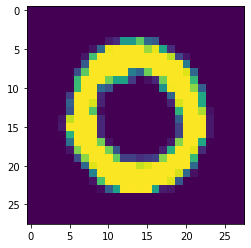

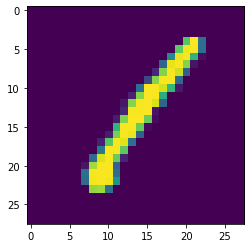

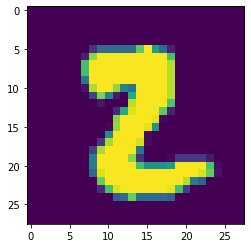

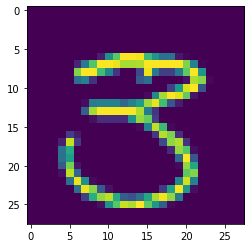

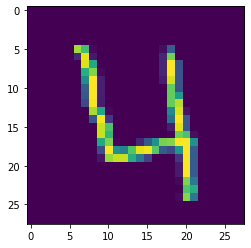

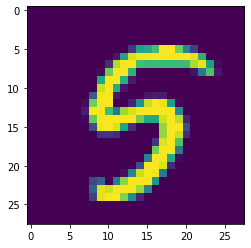

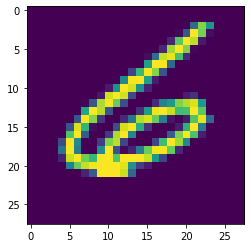

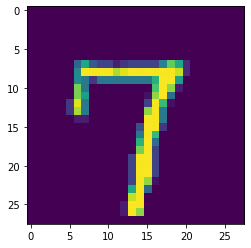

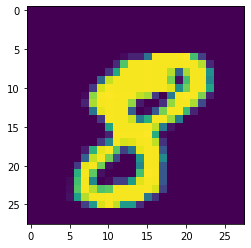

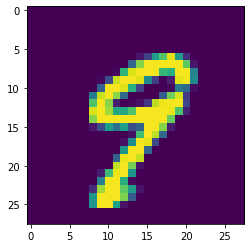

In [18]:
all_labels = train_data[target_label].unique()
all_labels.sort()

for label in all_labels:
    first_instance = train_data[train_data[target_label] == label].iloc[0]

    first_instance = first_instance.drop(target_label)

    values = first_instance.values.reshape(28,28)

    plt.imshow(values)
    plt.show()

# Part C) Examine the prior probability of the classes in the training data. Is it uniform across the digits? Display a normalized histogram of digit counts. Is it even?

0    0.098381
1    0.111524
2    0.099452
3    0.103595
4    0.096952
5    0.090357
6    0.098500
7    0.104786
8    0.096738
9    0.099714
Name: label, dtype: float64


<AxesSubplot:>

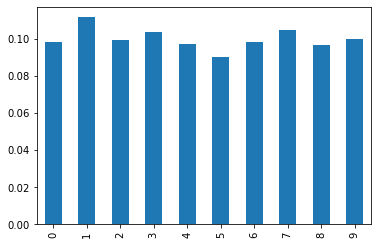

In [35]:
priors = train_data[target_label].value_counts(normalize=True).sort_index()

print(priors)

priors.plot(kind='bar', x=1)



This looks pretty even only 2 digits are greater than .005 away from the uniform proportion of .1

# Part D) Pick one example of each digit from your training data. Then, for each sample digit, compute and show the best match (nearest neighbor) between your chosen sample and the rest of the training data.

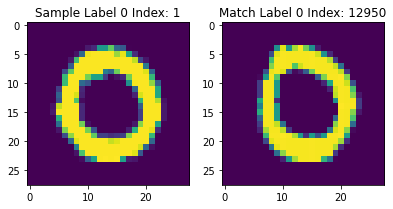

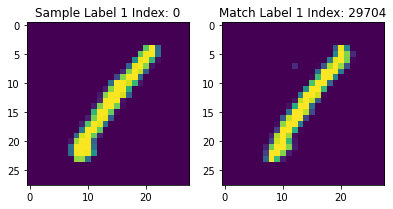

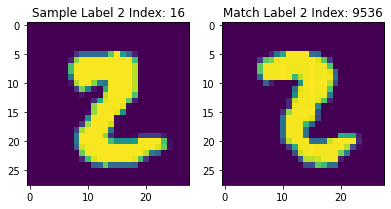

**********************


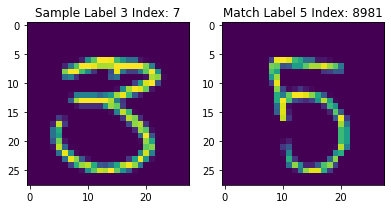

**********************


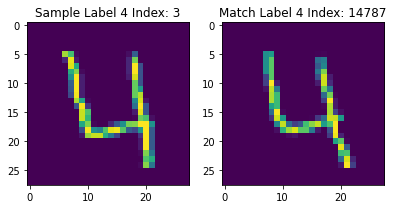

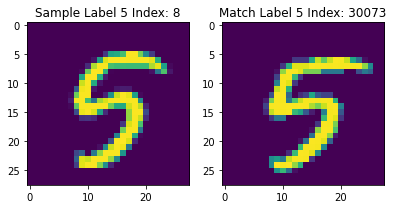

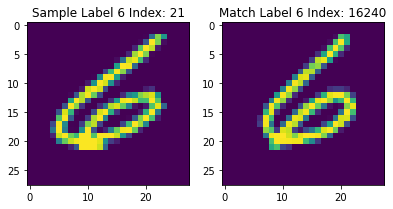

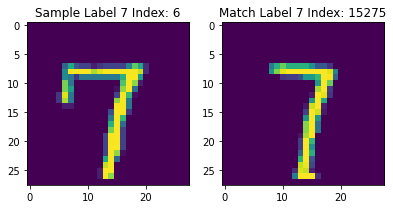

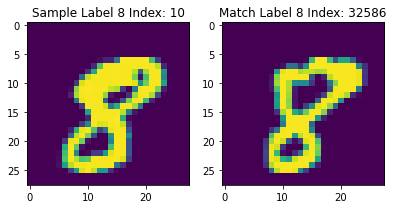

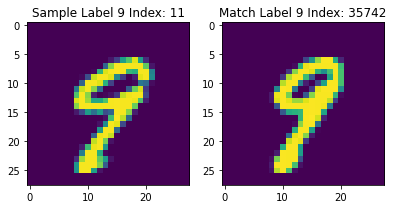

In [125]:

all_labels = train_data[target_label].unique()
all_labels.sort()

# Drop the target label from the feature data
dropLabels = train_data.drop(target_label, 1)

for label in all_labels:
    # Get the first instance of this label
    first_instance = train_data[train_data[target_label] == label].iloc[0]
    first_instance = first_instance.drop(target_label)
    
    # Remove sample instance from potential matches
    dropped_sample = dropLabels.drop(first_instance.name, errors = 'ignore')

    # Get L2 distance to all other instances
    all_distances = cdist(np.array([first_instance]), dropped_sample)

    # Get the closest match in the group
    closest_match = dropped_sample.iloc[np.argmin(all_distances,1)]
    match_index = closest_match.index[0]
    match_label = train_data.loc[match_index][target_label]

    # Reshape values for plotting
    sample_values = first_instance.values.reshape(28,28)
    match_values = closest_match.values.reshape(28,28)

    # Plot results

    
    if match_label != label:
        print("**********************")
        
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(sample_values)
    axarr[1].imshow(match_values)

    sampleTitle = 'Sample Label ' + str(label) + " Index: " + str(first_instance.name)
    matchTitle = 'Match Label ' + str(match_label) + " Index: " + str(match_index)

    axarr[0].title.set_text(sampleTitle)
    axarr[1].title.set_text(matchTitle)

    plt.show()
    
    if match_label != label:
        print("**********************")
    


# Part E) Consider the case of binary comparison between the digits 0 and 1. Ignoring all the other digits, compute the pairwise distances for all genuine matches and all impostor matches, again using the L2 norm. Plot histograms of the genuine and impostor distances on the same set of axes.

In [93]:
def binaryComparison(train_data, digits):
    
    # Filter everything that is not a 0 or 1
    filtered_digits = train_data[train_data[target_label].isin(digits)]
    filtered_digits = filtered_digits.iloc[:5000,:]

    # Drop labels from feature set
    features = filtered_digits.drop(target_label, 1)
    labels = filtered_digits[target_label]
    
    all_distances = cdist(features, features)
    
    match_indices = [[1 if j == i else 0 for j in labels] for i in labels]
    
    match_distances =[]
    no_match_distances = []
    
    for i in range(len(all_distances)):
        for j in range(i):
            if match_indices[i][j] == 1:
                match_distances.append(all_distances[i][j])
            else:
                no_match_distances.append(all_distances[i][j])

    print(len(match_distances))
    print(len(no_match_distances))

    print("done")
    print(np.average(match_distances))
    print(np.average(no_match_distances))

    plt.hist(match_distances, alpha=0.5, density = True, label = 'match')
    plt.hist(no_match_distances, alpha=0.5, density = True, label = 'no match')
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    return [match_distances, no_match_distances]
    
    

#self.getROCCurve(match_distances,no_match_distances, 100)



6281725
6215775
done
2017.0449273251415
2882.1784123531916


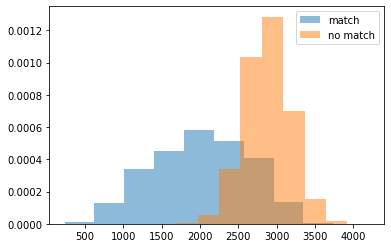

In [94]:
[match_distances, no_match_distances] = binaryComparison(train_data, [0,1])


# F) ) Generate an ROC curve from the above sets of distances. What is the equal error rate? What is the error rate of a classifier that simply guesses randomly?

In [95]:

def getROCCurve(match_distances, no_match_distances, steps):
    
    min_dist = min(match_distances + no_match_distances)
    max_dist = max(match_distances + no_match_distances)

    tp_rates = []
    fp_rates = []

    closestEqual = 1
    ERR = 0

    for i in range(steps + 1):
        cutoff = min_dist + i*(max_dist - min_dist)/steps

        [tps, fps, tns, fns] = [0,0,0,0]

        for dist in match_distances:
            if dist < cutoff:
                tps += 1
            else:
                fns += 1

        for dist in no_match_distances:
            if dist < cutoff:
                fps += 1
            else:
                tns += 1

        tpr = 1
        fpr = 0
        if tps + fns > 0:
            tpr = tps/(tps + fns)

        if fps + tns > 0:
            fpr = fps/(fps + tns)

        if abs(1 - tpr - fpr) < closestEqual:
            closestEqual = abs(1 - tpr - fpr)
            ERR = round(1 - tpr,3)


        tp_rates.append(tpr)
        fp_rates.append(fpr)

    plt.scatter(fp_rates, tp_rates, label = 'ROC Curve')

    plt.plot([0,1], [0,1], 'black', linestyle='--', marker='', label = 'Baseline')
    plt.plot([1,0], [0,1], 'grey', linestyle=':', marker='', label = 'ERR')
    #
    plt.xlabel("False Postive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Binary Digit Classification. ERR: " + str(ERR))
    plt.legend()

    plt.show()

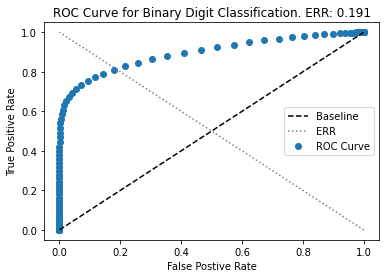

In [96]:
getROCCurve(match_distances, no_match_distances, 100)

In [ ]:
Equal error rate for a random guess would be .5 because this is a binary classification problem with balanced data

# Part G) Implement a K-NN classifier.

In [179]:
def KNNClassifier(knn_train, knn_test, k = 6, binaryFill = False):

    train_labels = knn_train[target_label]
    train_values = knn_train.drop(target_label, axis=1)

    if target_label in knn_test:
        test_values = knn_test.drop(target_label, axis=1)
    else:
        test_values = knn_test.copy()

        
    if binaryFill == True:
        train_values[train_values != 0] = 1
        test_values[test_values != 0] = 1

    all_distances = cdist(test_values, train_values)

    predictions = []
    
    for i in range(len(knn_test)):
        # Get the k nearest matches by getting the k indices of the k lowest distances
        ind = np.argpartition(all_distances[i], k)[:k]
        labels = train_labels.iloc[ind]
        
        most_common = labels.mode()
        
        if len(most_common) == 1:
            predicted_label = most_common.iloc[0]
            
        else:
            # Turn the neighbor distances into a series and combine with the labels
            distances = pd.Series([all_distances[i][x] for x in ind],
                                    index = labels.index,
                                    name = 'distance')

            neighordf = pd.concat([labels, distances], axis=1).reset_index()

            # Group by label amount nearest neighbors.
            # Get the frequency of that label and the average distnace of that label
            neighborstats = neighordf.groupby(target_label, as_index=False) \
                                    .agg(freq=(target_label,'count'),
                                        average=('distance','mean'))

            # First identify the most frequent labels amount the neighbors.
            # If there is only one most frequent label this is the predicted label
            most_common = neighborstats.loc[neighborstats['freq'] == neighborstats['freq'].max()]

            # Else, among the most common labels, we use the minimum average distance
            # as a tiebreaker
            bestIndex = most_common['average'].idxmin()

            # Return the predicted label and probabilities of each label 
            predicted_label = most_common.loc[bestIndex][target_label]
            probabilities = neighborstats.freq.value_counts(normalize=True)

        predictions.append(predicted_label)
        
    return predictions

# Part H) Randomly split the training data into two halves. Train your k-NN classifier on the first half of the data, and test it on the second half, reporting your average accuracy.

In [174]:

# Split train set into train and test set
sample_size = 42000

subset = train_data.iloc[:sample_size,:]

knn_train = subset.iloc[:int(sample_size/2),:]
knn_test = subset.iloc[int(sample_size/2):,:]

# We have found that changing the feature values from a pixel representing color to
# a binary 0 or 1 for whether or not there was any shading at that pixel results in a higher accuracy

predictions = KNNClassifier(knn_train, knn_test, k = 6, binaryFill = True)

actuals = knn_test[target_label]
accuracy = actuals == predictions

print("The average accuracy is " + str(np.average(accuracy)))



OH YEAH


NameError: name 'sad' is not defined

# Part I) Generate a confusion matrix (of size 10 × 10) from your results. Which digits are particularly tricky to classify?

In [170]:
def plotConfusion(actuals, predictions):
    cm = confusion_matrix(actuals, predictions, normalize = 'true')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    disp = disp.plot()

    disp.figure_.set_size_inches(15, 15, forward=True)


    plt.show()

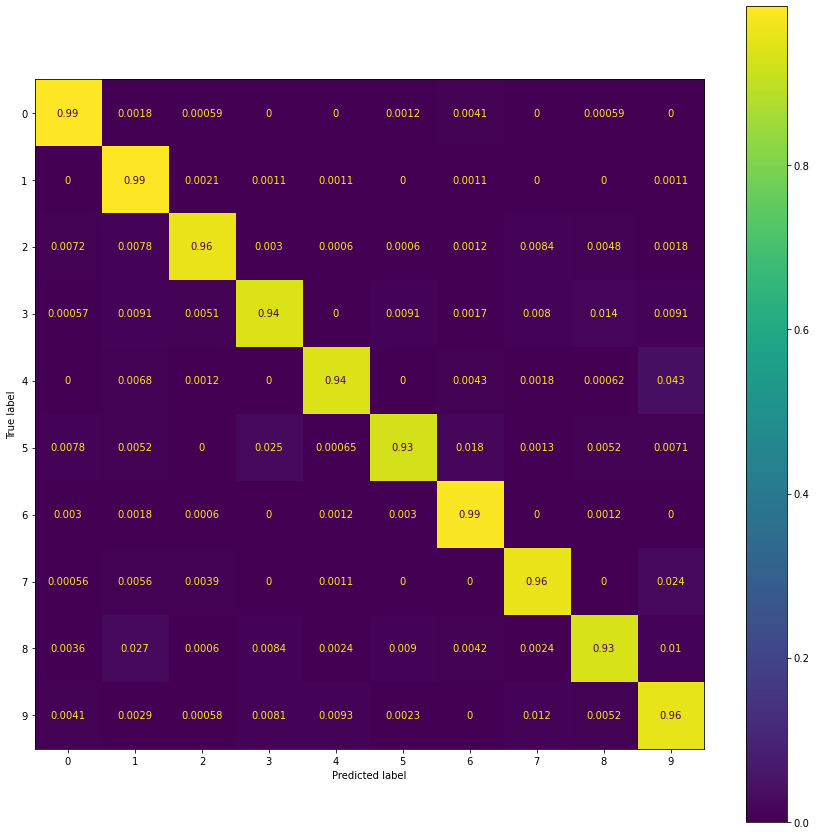

In [171]:

plotConfusion(actuals, predictions)


We see from the confusion matrix above that 5 and 8 are generally the most difficult to classify. We often confuse 5s with 6s and confuse 8s with 9s.

# Part J) Train your classifier with all of the training data, and test your classifier with the test data. Submit your results to Kaggle. 

In [185]:
import csv

predictions = KNNClassifier(train_data, test_data, k = 6, binaryFill = True)

with open('submission.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow(['ImageId','Label'])
    
    for i in range(len(predictions)):
        row = [i, predictions[i]]
        writer.writerow(row)
        